# (6) Inference from artificial data.

In this notebook we assess the ability of the SMC-ABC algorithm to infer known parameters from artificial simulated data from the SSA. This allows us to assess the ability of the SMC-ABC implemented to predict known parameters, as well as allowing us to assess whether the various objective functions have an impact on the inference.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [4]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## First attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\log_{10}(\alpha_0) = 0.5$, $\alpha_1 = 1.0$, $\log_{10}(\beta_0) = -1.8$ and $\beta_1 = 0.3$:

In [126]:
true_par = [1.0,0.3,0.0,0.1];

In [127]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, ssa[1]); append!(SSA_data_c, ssa[2]); append!(SSA_data_v, ssa[3]);
    end
    return convert(Array{Float64,2},transpose(SSA_data_n)), convert(Array{Float64,2},transpose(SSA_data_c)), SSA_data_v # return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [128]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1])[2];

Let's plot this data:

In [129]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings; pyplot()

Plots.PyPlotBackend()

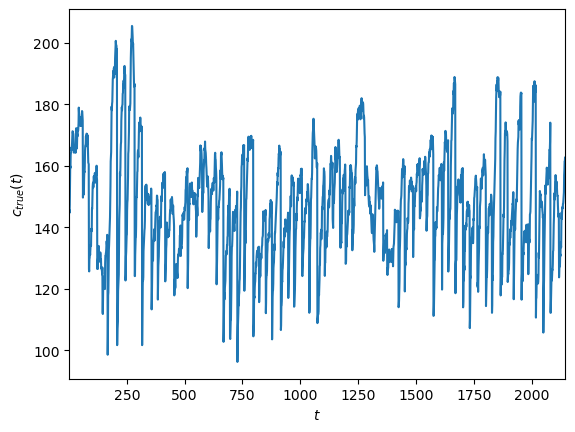

In [130]:
PyPlot.plot(range(1,length(expt_ssa_conc),step=1),expt_ssa_conc[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc)]);

Now let's set up the tools needed to perform the inference of the parameters as we did in notebook 5.

In [131]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params)
    lin_conc = Single_lin(lineage_data, var_params, lin_ic)[2]
    return lin_conc
end

simulator_function_conc (generic function with 1 method)

Start the inference:
- (1) `n_particles` gives the number of accepted ABC parameter sets for each step in the threshold simulator.
- (2) `threshold_schedule` gives the different thresholds for the SMC-ABC inference.
- (3) `reference_data_c` is the concentration data for the first 69 generations in lineage 1.
- (4) `priors` is the array containing the priors on each inferred parameter (chosen to be uniform).

┌ Info: GpABC rejection simulation. ϵ = 5000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 2500.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 61/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 121/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 165/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 195/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 1250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 11/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ I

┌ Info: GpABC SMC simulation accepted 181/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 199/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 550.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 1/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 3/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 4/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 11/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 11/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/ab

┌ Info: GpABC SMC simulation accepted 69/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 79/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 92/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 98/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 103/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 111/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 117/17000 particles.
└ @ GpABC /home/s1402978/.jul

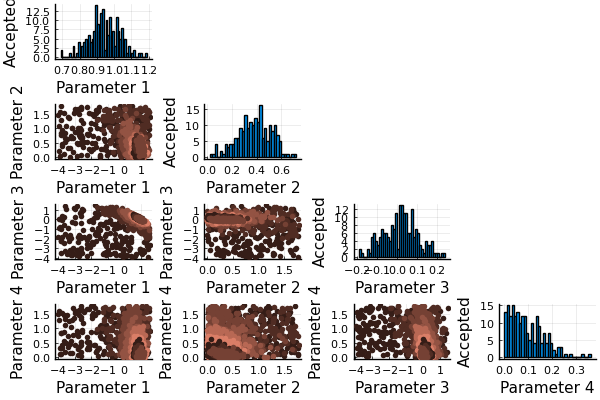

In [137]:
n_particles = 200;
threshold_schedule = [5000.0, 2500.0, 1250.0, 1000.0, 750.0, 675.0, 600.0, 550.0, 500.0]#, 350.0];

priors = [Uniform(-4.0, 1.5), Uniform(0.0, 1.8), Uniform(-4.0, 1.5),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(expt_ssa_conc,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67"]#,"#E57053"]#,"#E75935","#E84D26"]#,"#E84117"]#,"#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

Print the median inferred parameters.

In [151]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.938276842948806
 0.387376736766596
 0.022020888539581535
 0.07817472742067005

In [184]:
true_par

4-element Array{Float64,1}:
 1.0
 0.3
 0.0
 0.1

Print the differences.

In [152]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
 -0.06172315705119402
  0.08737673676659602
  0.022020888539581535
 -0.021825272579329952

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

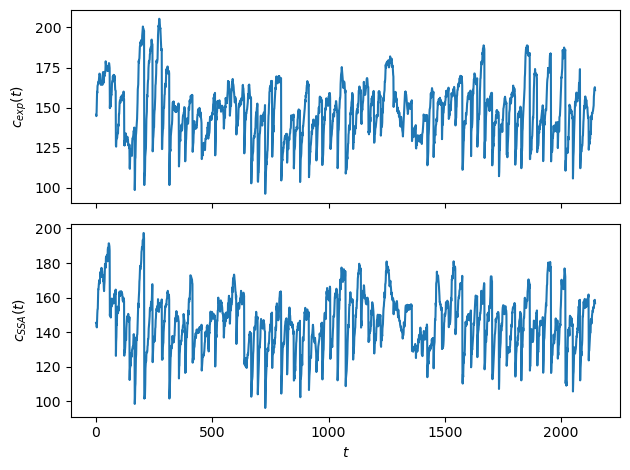

  0.011479 seconds (38.83 k allocations: 3.086 MiB)


In [140]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = single[2][1:length(single[2])]; expt_c = expt_ssa_conc[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

## Second inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\log_{10}(\alpha_0) = 0.5$, $\alpha_1 = 1.0$, $\log_{10}(\beta_0) = -1.8$ and $\beta_1 = 0$:

In [174]:
true_par_2 = [0.0,0.0001,0.5,1.0];

Question: can we infer $\beta_1 = 0$ without performing inference of $\beta_1$ in log scale? We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [175]:
expt_ssa_conc_2 = Single_lin(num_sep_all_lins[1], true_par_2, v0_n0_th[1])[2];

Let's plot this data:

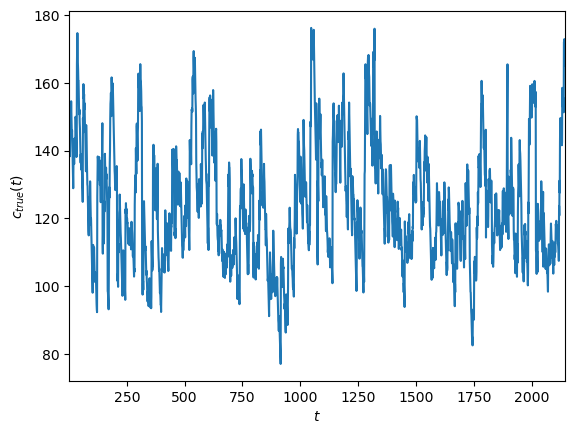

In [176]:
PyPlot.plot(range(1,length(expt_ssa_conc_2),step=1),expt_ssa_conc_2[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc_2)]);

┌ Info: GpABC rejection simulation. ϵ = 5000.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 2500.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 1250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 40/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 76/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 118/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 154/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 195/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ I

┌ Info: GpABC SMC simulation accepted 0/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 0/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/c

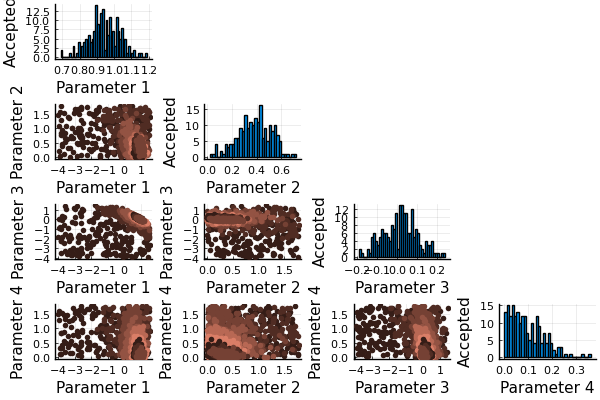

In [177]:
n_particles = 200;
threshold_schedule = [5000.0, 2500.0, 1250.0, 1000.0, 750.0, 675.0]#, 600.0, 550.0, 500.0]#, 350.0];

priors = [Uniform(-4.0, 1.5), Uniform(0.0, 1.8), Uniform(-4.0, 1.5),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(expt_ssa_conc_2,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67"]#,"#E57053"]#,"#E75935","#E84D26"]#,"#E84117"]#,"#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

Print the inferred median parameters.

In [178]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  1.137917906384076
  0.5743088844996609
 -0.5505186719113232
  0.22284826504002014

In [183]:
true_par_2

4-element Array{Float64,1}:
 0.0
 0.0001
 0.5
 1.0

Print the differences.

In [179]:
diff_2 = (pars_conc_2 - true_par_2)

4-element Array{Float64,1}:
  1.137917906384076
  0.5742088844996609
 -1.0505186719113233
 -0.7771517349599799

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

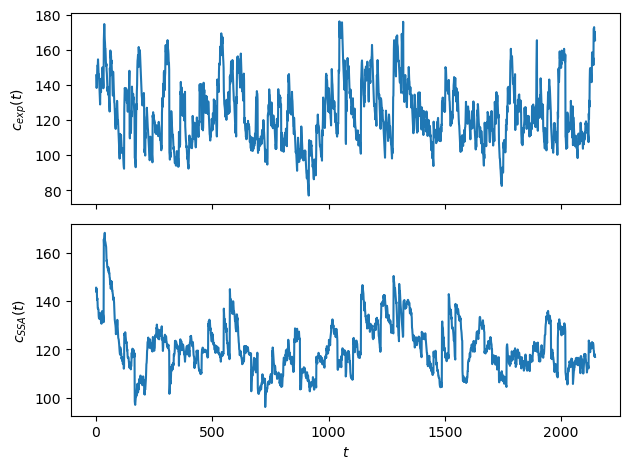

  0.019018 seconds (67.61 k allocations: 5.722 MiB)


In [180]:
single_2 = @time Single_lin(num_sep_all_lins[1], pars_conc_2, v0_n0_th[1]); # do for first gen.
concs_ssa_2 = single_2[2][1:length(single_2[2])]; expt_c_2 = expt_ssa_conc_2[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c_2),step=1),expt_c_2); axs[2].plot(range(1,length(concs_ssa_2),step=1),concs_ssa_2);

# Stuff below here is not relevant.

## Let's try inferring all the params in log-space

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\ln(\alpha_0) = -0.1$, $\ln(\alpha_1) = -0.2$, $\ln(\beta_0) = -2.0$ and $\ln(\beta_1) = -3.0$:

In [63]:
true_par_log = [-0.1, -0.2, -2.0, -3.0];

Question: can we infer $\beta_1 = 0$ without performing inference of $\beta_1$ in log scale? We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [25]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin_log(lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_all_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, ssa[1]); append!(SSA_data_c, ssa[2]); append!(SSA_data_v, ssa[3]);
    end
    return convert(Array{Float64,2},transpose(SSA_data_n)), convert(Array{Float64,2},transpose(SSA_data_c)), SSA_data_v # return in the same order as the SSA.
end

Single_lin_log (generic function with 1 method)

In [45]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc_log(var_params)
    lin_conc = Single_lin_log(lineage_data, var_params, lin_ic)[2]
    return lin_conc
end

simulator_function_conc_log (generic function with 1 method)

In [49]:
expt_ssa_conc_log = Single_lin_log(num_sep_all_lins[1], true_par_log, v0_n0_th[1])[2];

Let's plot this data:

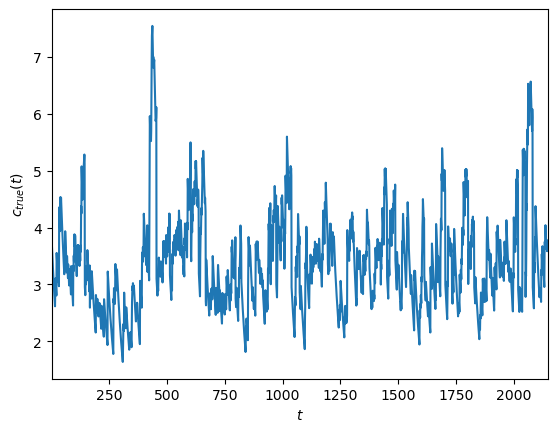

In [50]:
PyPlot.plot(range(1,length(expt_ssa_conc_log),step=1),expt_ssa_conc_log[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc_log)]);

Difficulty with inferring in the log space is that the inference parameters are much more sensitive to perturbation, hence zooming in on the minimum of the objective function can be quite difficult. Hence we must carefully choose our thresholds.

┌ Info: GpABC rejection simulation. ϵ = 75.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 60.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 150/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 50.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 28/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 65/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 105/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 134/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: G

┌ Info: GpABC SMC simulation accepted 183/43000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 184/44000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 191/45000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 195/46000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 199/47000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 44.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 3/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 5/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3w

┌ Info: GpABC SMC simulation accepted 114/59000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 116/60000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 120/61000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 121/62000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 125/63000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 127/64000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 129/65000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 130/66000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 17/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 21/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 22/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 23/26000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 27/27000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 27/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 27/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 28/30000 particles.
└ @ GpABC /home/s1402978/.julia/

┌ Info: GpABC SMC simulation accepted 83/87000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 86/88000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 87/89000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 87/90000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 87/91000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 89/92000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 90/93000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 91/94000 particles.
└ @ GpABC /home/s1402978/.julia/

┌ Warning: Simulation reached maximum 150000 iterations before finding 200 particles - will return 134
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:248


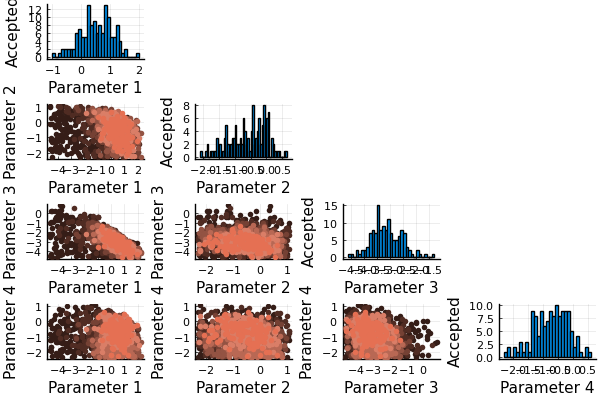

In [76]:
n_particles = 200;
threshold_schedule = [75.0, 60.0, 50.0, 47.5, 45.0, 44.0, 43.0]#, 41.25, 40.5, 40.0]#, 35.0, 33.75, 32.5, 31.25, 30.0]#, 29.0, 28.0, 27.5];

priors = [Uniform(-2.0*log(10), log(10)), Uniform(-log(10), log(3.0)), 
                Uniform(-2.0*log(10), log(10)), Uniform(-log(10), log(3.0))];

sim_abcsmc_res_conc_log = SimulatedABCSMC(expt_ssa_conc_log,
    simulator_function_conc_log,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    max_iter = convert(Int,15E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053"]#,"#E75935","#E84D26"]#,"#E84117","#CF3008","#AB2402"]#,"#351D17"]
plot(sim_abcsmc_res_conc_log, population_colors=population_colors)

Print the inferred median parameters.

In [73]:
pars_conc_log = [median(sim_abcsmc_res_conc_log.population[end-3][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  0.890662935753691
 -1.6418122547317917
 -3.5388371535541854
 -0.4250385367160655

Print the differences.

In [74]:
diff_log = (pars_conc_log - true_par_log)

4-element Array{Float64,1}:
  0.990662935753691
 -1.4418122547317918
 -1.5388371535541854
  2.5749614632839344

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

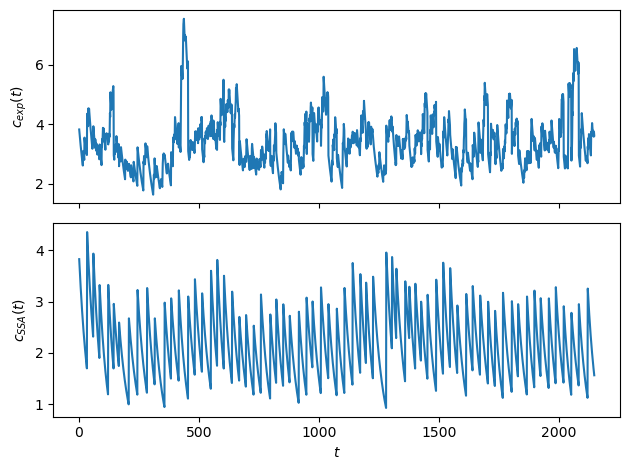

  0.001524 seconds (12.95 k allocations: 734.641 KiB)


In [77]:
single_log = @time Single_lin(num_sep_all_lins[1], pars_conc_log, v0_n0_th[1]); # do for first gen.
concs_ssa_log = single_log[2][1:length(single_log[2])]; expt_c_log = expt_ssa_conc_log[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c_log),step=1),expt_c_log); axs[2].plot(range(1,length(concs_ssa_log),step=1),concs_ssa_log);